In [1]:
import torch

In [2]:
torch.__version__

'2.3.0+cpu'

In [3]:
print(torch.cuda.is_available())

False


In [4]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torchaudio #install pytorch in conda shell
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from torchsummary import summary # 

In [5]:
import src.preprocessor as preprocessor

In [6]:
#plt.style.use("ggplot")

In [7]:
torch.manual_seed(2)

# Speech Classification Pipeline
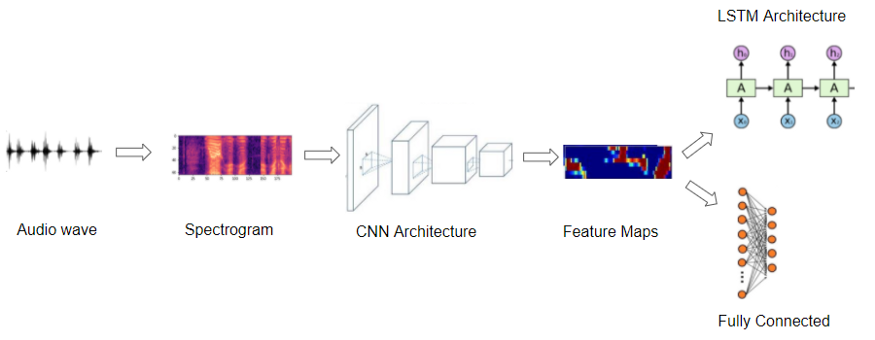

source: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

## Data exploration

Metadata from one recording per class

In [8]:
#accents_path = "./accentdb_extended/data" # The directory with the accent_db data
#accents_path = "C:\Users\peter\VoxPop\sample_output_directory"

#accents_path="/Users/peter/VoxPop/sample_output_directory/" 
accents_path="C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\" 

#os.getcwd()
#os.listdir(accents_path)

In [9]:
'''
for i, accent_dir in enumerate(os.listdir(accents_path)):
    dir_path = accents_path + "/" + accent_dir + "/"
    print(accent_dir)
    for file in os.listdir(dir_path):
        file_path = dir_path + file
        print(i)
        print(file_path)
        print(torchaudio.info(file_path))
        #x, sr = librosa.load("./accentdb_extended/data/bangla/bangla_s01_115.wav")
        x, sr = librosa.load(file_path)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(y=x, sr=sr, color="b")
        plt.show()
        break
'''

'\nfor i, accent_dir in enumerate(os.listdir(accents_path)):\n    dir_path = accents_path + "/" + accent_dir + "/"\n    print(accent_dir)\n    for file in os.listdir(dir_path):\n        file_path = dir_path + file\n        print(i)\n        print(file_path)\n        print(torchaudio.info(file_path))\n        #x, sr = librosa.load("./accentdb_extended/data/bangla/bangla_s01_115.wav")\n        x, sr = librosa.load(file_path)\n        plt.figure(figsize=(10, 4))\n        librosa.display.waveshow(y=x, sr=sr, color="b")\n        plt.show()\n        break\n'

## New DataFrame Handling


In [10]:
df1=pd.read_pickle(accents_path+'20240720_2122_DUB_features.pkl') #i9 locations

In [11]:
# read CSV version
#
# df1 = pd.read_csv(accents_path+'20240622_2202_DUB_features.csv', index_col=0)

In [12]:
df1[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,"[1.5543122e-15, 3.330669e-15, 3.5527137e-15, 3...","[[-45.312862, -45.312862, -20.940594, -15.0561...",22050,"[[-655.949, -615.1495, -328.68915, -242.04138,...","[[49.801403, 49.801403, 49.801403, 49.801403, ...","[[-30.38227, -30.38227, -30.38227, -30.38227, ..."
1,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,"[-0.008644444, -0.01465759, -0.012110229, 0.00...","[[-34.0381, -32.152866, -36.18184, -49.078957,...",22050,"[[-280.54608, -219.32281, -217.8543, -227.0891...","[[16.633562, 16.633562, 16.633562, 16.633562, ...","[[-3.0967958, -3.0967958, -3.0967958, -3.09679..."
2,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,"[-0.013591497, -0.009562584, -0.0034573623, 0....","[[-26.495678, -26.199865, -34.241257, -27.4409...",22050,"[[-334.6902, -300.3063, -289.8084, -286.79123,...","[[5.437888, 5.437888, 5.437888, 5.437888, 5.43...","[[-1.3182307, -1.3182307, -1.3182307, -1.31823..."


In [13]:
df2 = pd.read_pickle(accents_path+'20240721_0013_ANT_features.pkl')
# 
# df2 = pd.read_csv(accents_path+'20240622_2146_ANT_features.csv', index_col=0)

In [14]:
df2[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,0,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."


In [15]:
recordings1=df1['recording num'].max()
recordings1

166

In [16]:
df2['recording num']

0        0
1        0
2        0
3        0
4        0
        ..
6489    65
6490    65
6491    65
6492    65
6493    65
Name: recording num, Length: 6494, dtype: object

In [17]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
df2['recording num']=df2['recording num']+recordings1
df2['recording num']

0       166
1       166
2       166
3       166
4       166
       ... 
6489    231
6490    231
6491    231
6492    231
6493    231
Name: recording num, Length: 6494, dtype: object

In [18]:
# Concatenate the DataFrames
input_df = pd.concat([df1, df2])

In [19]:
input_df.shape

(21594, 18)

In [20]:
input_df = input_df.reset_index(drop=True)

In [21]:
input_df['recording num']

0          0
1          0
2          0
3          0
4          0
        ... 
21589    231
21590    231
21591    231
21592    231
21593    231
Name: recording num, Length: 21594, dtype: object

In [22]:
input_df[:5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,"[1.5543122e-15, 3.330669e-15, 3.5527137e-15, 3...","[[-45.312862, -45.312862, -20.940594, -15.0561...",22050,"[[-655.949, -615.1495, -328.68915, -242.04138,...","[[49.801403, 49.801403, 49.801403, 49.801403, ...","[[-30.38227, -30.38227, -30.38227, -30.38227, ..."
1,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,"[-0.008644444, -0.01465759, -0.012110229, 0.00...","[[-34.0381, -32.152866, -36.18184, -49.078957,...",22050,"[[-280.54608, -219.32281, -217.8543, -227.0891...","[[16.633562, 16.633562, 16.633562, 16.633562, ...","[[-3.0967958, -3.0967958, -3.0967958, -3.09679..."
2,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,"[-0.013591497, -0.009562584, -0.0034573623, 0....","[[-26.495678, -26.199865, -34.241257, -27.4409...",22050,"[[-334.6902, -300.3063, -289.8084, -286.79123,...","[[5.437888, 5.437888, 5.437888, 5.437888, 5.43...","[[-1.3182307, -1.3182307, -1.3182307, -1.31823..."
3,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,3,DUB_Artane_M_20_Rec_0_Sample_3.wav,"[0.012625188, 0.019961715, 0.025324743, 0.0241...","[[-24.227428, -26.599072, -47.74459, -41.58653...",22050,"[[-229.78705, -204.62209, -229.6079, -220.1116...","[[1.6047139, 1.6047139, 1.6047139, 1.6047139, ...","[[-4.0145516, -4.0145516, -4.0145516, -4.01455..."
4,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,4,DUB_Artane_M_20_Rec_0_Sample_4.wav,"[0.0034307502, -0.000913774, -0.0044430313, -0...","[[-14.608098, -19.742035, -22.976656, -22.9132...",22050,"[[-332.36176, -294.2127, -260.09448, -192.7378...","[[21.142487, 21.142487, 21.142487, 21.142487, ...","[[-7.5529113, -7.5529113, -7.5529113, -7.55291..."


## Initial Data Analysis and Data Cleaning

In [23]:
input_df['counties'].value_counts()

counties
DUB    15100
ANT     3998
BEL     2496
Name: count, dtype: int64

The observations will be separated by geographic origin by county, the Belfast and Antrim observations will be one class, Dublin another

Merge BEL and ANT with a common county value 

In [24]:
input_df['counties'] = input_df['counties'].replace({'ANT': 'ANTBEL', 'BEL': 'ANTBEL'})

In [25]:
input_df['counties'].value_counts()

counties
DUB       15100
ANTBEL     6494
Name: count, dtype: int64

In [26]:
num_antbel=(input_df['counties']=='ANTBEL').sum()
num_antbel

6494

In [27]:
num_dub=(input_df['counties']=='DUB').sum()
num_dub

15100

Calculate the weights, the proportion of the total accounted for by each class

In [28]:
weight_dub=num_dub/(num_dub+num_antbel)
weight_dub

0.6992683152727609

In [29]:
weight_antbel=num_antbel/(num_dub+num_antbel)
weight_antbel

0.30073168472723905

In [30]:
class_weights = torch.tensor([weight_dub, weight_antbel],dtype=torch.float)
class_weights

tensor([0.6993, 0.3007])

Create a binary class marker also

In [31]:
mapping = {'DUB': 0, 'ANTBEL': 1}
input_df['class_id'] = input_df['counties'].map(mapping)

In [32]:
input_df[:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
0,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,0,DUB_Artane_M_20_Rec_0_Sample_0.wav,"[1.5543122e-15, 3.330669e-15, 3.5527137e-15, 3...","[[-45.312862, -45.312862, -20.940594, -15.0561...",22050,"[[-655.949, -615.1495, -328.68915, -242.04138,...","[[49.801403, 49.801403, 49.801403, 49.801403, ...","[[-30.38227, -30.38227, -30.38227, -30.38227, ...",0
1,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,1,DUB_Artane_M_20_Rec_0_Sample_1.wav,"[-0.008644444, -0.01465759, -0.012110229, 0.00...","[[-34.0381, -32.152866, -36.18184, -49.078957,...",22050,"[[-280.54608, -219.32281, -217.8543, -227.0891...","[[16.633562, 16.633562, 16.633562, 16.633562, ...","[[-3.0967958, -3.0967958, -3.0967958, -3.09679...",0
2,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_A...,DUB_Artane_M_20,DUB,Artane,None,None,M,20,81.0,0,2,DUB_Artane_M_20_Rec_0_Sample_2.wav,"[-0.013591497, -0.009562584, -0.0034573623, 0....","[[-26.495678, -26.199865, -34.241257, -27.4409...",22050,"[[-334.6902, -300.3063, -289.8084, -286.79123,...","[[5.437888, 5.437888, 5.437888, 5.437888, 5.43...","[[-1.3182307, -1.3182307, -1.3182307, -1.31823...",0


Count the numbers of male and female speakers in the sample recordings

In [33]:
input_df['genders'][input_df['genders']=='M'].count()

11948

In [34]:
input_df['genders'][input_df['genders']=='F'].count()

9646

In [35]:
input_df[-4:-1]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
21590,C:\Users\GGMachines_Gaming\Documents\ANT\BEL_W...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,None,None,M,20,100.34,231,96,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,"[0.024601525, 0.015888121, 0.0046198685, -0.00...","[[-4.803353, -11.617571, -29.300434, -20.59833...",22050,"[[-301.1829, -277.05615, -226.86594, -190.4626...","[[10.678157, 10.678157, 10.678157, 10.678157, ...","[[-7.9928646, -7.9928646, -7.9928646, -7.99286...",1
21591,C:\Users\GGMachines_Gaming\Documents\ANT\BEL_W...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,None,None,M,20,100.34,231,97,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,"[-0.0023768325, -0.0011759233, -0.0016920944, ...","[[-20.16156, -26.001833, -25.968048, -23.75188...",22050,"[[-359.23972, -324.38934, -312.734, -302.84528...","[[3.5034277, 3.5034277, 3.5034277, 3.5034277, ...","[[-4.295142, -4.295142, -4.295142, -4.295142, ...",1
21592,C:\Users\GGMachines_Gaming\Documents\ANT\BEL_W...,BEL_Whitehouse_M_20_(13),ANTBEL,Whitehouse,None,None,M,20,100.34,231,98,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,"[0.028287567, 0.00067837536, -0.035430364, -0....","[[-12.030594, -17.107288, -25.980743, -21.7605...",22050,"[[-215.84581, -213.88025, -244.97322, -273.715...","[[-8.783432, -8.783432, -8.783432, -8.783432, ...","[[4.6542344, 4.6542344, 4.6542344, 4.6542344, ...",1


In [36]:
# create a dataframe from the input dataframes
df = pd.DataFrame(input_df[['sample file name','class_id','counties','recording num']])

In [37]:
df = df.rename(columns={'sample file name': 'file_path', 'class_id': 'class_id', 'counties': 'class_name'})

In [38]:
df

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0
...,...,...,...,...
21589,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_95.wav,1,ANTBEL,231
21590,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_96.wav,1,ANTBEL,231
21591,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_97.wav,1,ANTBEL,231
21592,BEL_Whitehouse_M_20_(13)_Rec_65_Sample_98.wav,1,ANTBEL,231


In [39]:
'''
# create a dataframe for further usage

rows = []
for i, file in enumerate(os.listdir(accents_path)):
    if file.endswith(".wav"):
        rows.append(["/" + accents_path + file, i, accent_dir])
    else:
        continue
    
    wav_files = [file for file in files_in_directory if file.endswith('.csv')]
    for file in os.listdir(dir_path):
        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])

df = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])
df.head(10)
'''

'\n# create a dataframe for further usage\n\nrows = []\nfor i, file in enumerate(os.listdir(accents_path)):\n    if file.endswith(".wav"):\n        rows.append(["/" + accents_path + file, i, accent_dir])\n    else:\n        continue\n    \n    wav_files = [file for file in files_in_directory if file.endswith(\'.csv\')]\n    for file in os.listdir(dir_path):\n        rows.append(["/" + accent_dir + "/" + file, i, accent_dir])\n\ndf = pd.DataFrame(rows, columns=["file_path", "class_id", "class_name"])\ndf.head(10)\n'

In [40]:
df.shape

(21594, 4)

## Data preprocessing

In [47]:
class SpeechDataset(Dataset):
    def __init__(self, data_fr, data_path):
        self.data_fr = data_fr
        self.data_path = str(data_path)
  
    def __len__(self):
        return len(self.data_fr)

    def __getitem__(self, idx):
        audio_file = self.data_path + self.data_fr.loc[idx, "file_path"]
        class_id = self.data_fr.loc[idx, "class_id"]
        aud = preprocessor.load_audio(audio_file)
        rechannel = preprocessor.double_channel(aud)
        downsampl = preprocessor.downsample(rechannel)
        timed = preprocessor.append_trunc(downsampl)
        specgram = preprocessor.spectro_mfcc(timed)
        return specgram, class_id

In [48]:
num_f=(input_df['genders']=='F').sum()
df_f=input_df[input_df['genders']=='F']
num_f

9646

In [49]:
num_m=(input_df['genders']=='M').sum()
df_m=input_df[input_df['genders']=='M']
num_m

11948

In [50]:
df_f.shape

(9646, 19)

In [51]:
np.sort(df_f['recording num'].unique())

array([3, 4, 5, 8, 9, 10, 11, 12, 13, 18, 19, 20, 25, 26, 27, 29, 31, 35,
       36, 37, 39, 40, 41, 42, 44, 45, 46, 50, 51, 53, 55, 56, 57, 58, 61,
       62, 63, 64, 69, 73, 76, 77, 82, 83, 84, 86, 87, 91, 92, 93, 95, 96,
       98, 100, 102, 103, 107, 108, 109, 112, 113, 114, 115, 116, 122,
       123, 124, 125, 129, 130, 131, 134, 136, 137, 138, 141, 142, 151,
       152, 153, 154, 157, 158, 159, 160, 164, 166, 169, 175, 176, 180,
       181, 183, 185, 186, 192, 193, 195, 196, 198, 199, 205, 206, 207,
       208, 216, 217, 218], dtype=object)

In [52]:
df_f['recording num'].unique().shape[0]

108

In [53]:
np.sort(df_m['recording num'].unique())

array([0, 1, 2, 6, 7, 14, 15, 16, 17, 21, 22, 23, 24, 28, 30, 32, 33, 34,
       38, 43, 47, 48, 49, 52, 54, 59, 60, 65, 66, 67, 68, 70, 71, 72, 74,
       75, 78, 79, 80, 81, 85, 88, 89, 90, 94, 97, 99, 101, 104, 105, 106,
       110, 111, 117, 118, 119, 120, 121, 126, 127, 128, 132, 133, 135,
       139, 140, 143, 144, 145, 146, 147, 148, 149, 150, 155, 156, 161,
       162, 163, 165, 167, 168, 170, 171, 172, 173, 174, 177, 178, 179,
       182, 184, 187, 188, 189, 190, 191, 194, 197, 200, 201, 202, 203,
       204, 209, 210, 211, 212, 213, 214, 215, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231], dtype=object)

In [54]:
df_m['recording num'].unique().shape[0]

124

In [55]:
os.getcwd()

'C:\\Users\\GGMachines_Gaming\\Documents\\voxpop'

In [56]:
input_df['filenames'][0]

'C:\\Users\\GGMachines_Gaming\\Documents\\DUB\\DUB_Artane_M_20.wav'

In [57]:
input_df[input_df['recording num']==5]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2,class_id
442,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,0,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_0.wav,"[3.903128e-18, 6.938894e-18, 3.903128e-18, -1....","[[-34.160736, -34.160736, -34.160736, -34.1607...",22050,"[[-543.9816, -543.9816, -474.01495, -387.9184,...","[[25.992067, 25.992067, 25.992067, 25.992067, ...","[[-11.161288, -11.161288, -11.161288, -11.1612...",0
443,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,1,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_1.wav,"[-0.08242799, -0.0903963, -0.0868418, -0.08496...","[[-34.217854, -21.123123, -19.704548, -31.3195...",22050,"[[-209.47318, -212.26, -243.40407, -195.30678,...","[[-4.382596, -4.382596, -4.382596, -4.382596, ...","[[-8.445355, -8.445355, -8.445355, -8.445355, ...",0
444,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,2,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_2.wav,"[0.03617488, 0.02190169, 0.003979884, -0.01374...","[[7.040368, 11.601768, -4.4614105, 12.745926, ...",22050,"[[-196.49644, -168.15414, -188.24686, -270.743...","[[-33.115665, -33.115665, -33.115665, -33.1156...","[[-0.81686234, -0.81686234, -0.81686234, -0.81...",0
445,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,3,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_3.wav,"[-0.07683568, -0.075836234, -0.07926324, -0.08...","[[-8.871327, -13.627343, -24.220161, -30.58564...",22050,"[[-278.21466, -299.814, -276.30798, -250.61456...","[[-0.0404775, -0.0404775, -0.0404775, -0.04047...","[[-4.2527666, -4.2527666, -4.2527666, -4.25276...",0
446,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,4,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_4.wav,"[0.0019294731, 0.008288931, 0.00013422966, -0....","[[-38.503456, -25.950909, -23.000187, -22.0402...",22050,"[[-295.45038, -248.0887, -264.53714, -302.4702...","[[-1.017101, -1.017101, -1.017101, -1.017101, ...","[[-7.0652766, -7.0652766, -7.0652766, -7.06527...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,93,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_93.wav,"[-0.014656043, -0.016416281, -0.016274229, -0....","[[-11.280799, -27.772106, -2.7039723, 10.44259...",22050,"[[-299.83786, -226.94632, -198.24603, -213.191...","[[-9.929618, -9.929618, -9.929618, -9.929618, ...","[[-4.1002717, -4.1002717, -4.1002717, -4.10027...",0
536,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,94,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_94.wav,"[0.00280385, 0.0028709539, 0.00456078, 0.00394...","[[-29.87461, -28.735374, -16.747526, -18.35617...",22050,"[[-436.24133, -408.01105, -410.0607, -391.2307...","[[6.002024, 6.002024, 6.002024, 6.002024, 6.00...","[[-2.5775547, -2.5775547, -2.5775547, -2.57755...",0
537,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,95,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_95.wav,"[0.0008939381, 0.00049466174, 0.0029245992, 0....","[[-28.15521, -27.282707, -30.020884, -14.32178...",22050,"[[-425.20737, -351.02698, -311.428, -268.26385...","[[23.272404, 23.272404, 23.272404, 23.272404, ...","[[-11.350251, -11.350251, -11.350251, -11.3502...",0
538,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_B...,DUB_Ballinteer_F_20_(3),DUB,Ballinteer,None,None,F,20,98.0,5,96,DUB_Ballinteer_F_20_(3)_Rec_5_Sample_96.wav,"[0.2641878, 0.30334672, 0.3274039, 0.33971906,...","[[8.238987, 2.4613662, -31.796682, -20.61309, ...",22050,"[[-146.23788, -170.28624, -208.75696, -220.621...","[[-6.8

In [58]:
df_m.shape

(11948, 19)

In [59]:
#Select either the male or the female subset of samples only
#df=df_m
#df=df_f

In [60]:
df=df.reset_index(drop=True)

## Split into train and validate datasets

In [61]:
# Select samples for training and validation by SPEAKER i.e. by recording number
# Random split of 80:20 between training and validation
num_items = df.shape[0]
num_train = round(num_items * 0.7)
num_val = num_items - num_train


In [62]:
print(num_items)
print(num_train)
print(num_val)

21594
15116
6478


In [63]:
unique_recordings = df['recording num'].unique()
np.random.shuffle(unique_recordings)  # Shuffle the unique values

# Determine the split index
split_index = int(len(unique_recordings) * 0.7)


In [64]:
df['recording num'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

In [65]:
unique_recordings

array([168, 78, 58, 197, 149, 193, 222, 141, 83, 164, 57, 131, 171, 218,
       153, 148, 123, 77, 195, 163, 192, 37, 3, 162, 8, 34, 50, 227, 10,
       101, 17, 223, 1, 143, 147, 120, 90, 155, 224, 51, 117, 103, 88,
       217, 48, 47, 181, 109, 167, 201, 52, 174, 61, 177, 71, 226, 45, 74,
       146, 169, 134, 135, 40, 180, 206, 188, 202, 66, 75, 189, 106, 152,
       219, 24, 64, 126, 225, 26, 203, 208, 14, 15, 81, 173, 205, 191, 86,
       105, 118, 7, 72, 176, 33, 210, 214, 9, 132, 198, 95, 130, 185, 99,
       216, 28, 150, 122, 116, 31, 23, 79, 30, 59, 73, 0, 20, 49, 60, 156,
       199, 27, 35, 56, 196, 140, 212, 190, 179, 229, 172, 2, 154, 215,
       160, 178, 11, 43, 187, 108, 102, 115, 138, 200, 145, 110, 127, 97,
       22, 124, 84, 65, 144, 70, 121, 53, 228, 41, 166, 5, 38, 12, 182,
       151, 25, 125, 87, 207, 165, 113, 39, 55, 85, 100, 211, 107, 19,
       119, 18, 230, 89, 112, 129, 96, 93, 175, 159, 82, 186, 32, 221, 46,
       194, 157, 213, 67, 91, 184, 92, 136, 23

In [66]:
unique_recordings.shape

(232,)

In [67]:
unique_recordings.max()

231

In [68]:
unique_recordings[:split_index]

array([168, 78, 58, 197, 149, 193, 222, 141, 83, 164, 57, 131, 171, 218,
       153, 148, 123, 77, 195, 163, 192, 37, 3, 162, 8, 34, 50, 227, 10,
       101, 17, 223, 1, 143, 147, 120, 90, 155, 224, 51, 117, 103, 88,
       217, 48, 47, 181, 109, 167, 201, 52, 174, 61, 177, 71, 226, 45, 74,
       146, 169, 134, 135, 40, 180, 206, 188, 202, 66, 75, 189, 106, 152,
       219, 24, 64, 126, 225, 26, 203, 208, 14, 15, 81, 173, 205, 191, 86,
       105, 118, 7, 72, 176, 33, 210, 214, 9, 132, 198, 95, 130, 185, 99,
       216, 28, 150, 122, 116, 31, 23, 79, 30, 59, 73, 0, 20, 49, 60, 156,
       199, 27, 35, 56, 196, 140, 212, 190, 179, 229, 172, 2, 154, 215,
       160, 178, 11, 43, 187, 108, 102, 115, 138, 200, 145, 110, 127, 97,
       22, 124, 84, 65, 144, 70, 121, 53, 228, 41, 166, 5, 38, 12, 182,
       151], dtype=object)

In [69]:
unique_recordings[:split_index].shape[0]

162

In [70]:
unique_recordings[split_index:]

array([25, 125, 87, 207, 165, 113, 39, 55, 85, 100, 211, 107, 19, 119, 18,
       230, 89, 112, 129, 96, 93, 175, 159, 82, 186, 32, 221, 46, 194,
       157, 213, 67, 91, 184, 92, 136, 231, 183, 80, 13, 137, 63, 139,
       133, 142, 16, 128, 161, 111, 209, 170, 76, 44, 42, 220, 104, 114,
       69, 4, 62, 158, 29, 21, 94, 54, 6, 204, 68, 36, 98], dtype=object)

In [71]:
unique_recordings[split_index:].shape[0]

70

In [72]:
# Split the unique values into two sets (70% and 30%)
recording_train = unique_recordings[:split_index]
recording_val = unique_recordings[split_index:]

# Create two new DataFrames based on the split unique values
df_train = df[df['recording num'].isin(recording_train)].reset_index(drop=True)
df_val = df[df['recording num'].isin(recording_val)].reset_index(drop=True)

In [73]:
df_train.shape

(15163, 4)

In [74]:
df_train['recording num'].unique()

array([0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 20, 22, 23, 24, 26,
       27, 28, 30, 31, 33, 34, 35, 37, 38, 40, 41, 43, 45, 47, 48, 49, 50,
       51, 52, 53, 56, 57, 58, 59, 60, 61, 64, 65, 66, 70, 71, 72, 73, 74,
       75, 77, 78, 79, 81, 83, 84, 86, 88, 90, 95, 97, 99, 101, 102, 103,
       105, 106, 108, 109, 110, 115, 116, 117, 118, 120, 121, 122, 123,
       124, 126, 127, 130, 131, 132, 134, 135, 138, 140, 141, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 160,
       162, 163, 164, 166, 167, 168, 169, 171, 172, 173, 174, 176, 177,
       178, 179, 180, 181, 182, 185, 187, 188, 189, 190, 191, 192, 193,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 208, 210,
       212, 214, 215, 216, 217, 218, 219, 222, 223, 224, 225, 226, 227,
       228, 229], dtype=object)

In [75]:
df_train['recording num'].unique().shape

(162,)

In [76]:
df_val.shape

(6431, 4)

In [77]:
df_val['recording num'].unique()

array([4, 6, 13, 16, 18, 19, 21, 25, 29, 32, 36, 39, 42, 44, 46, 54, 55,
       62, 63, 67, 68, 69, 76, 80, 82, 85, 87, 89, 91, 92, 93, 94, 96, 98,
       100, 104, 107, 111, 112, 113, 114, 119, 125, 128, 129, 133, 136,
       137, 139, 142, 157, 158, 159, 161, 165, 170, 175, 183, 184, 186,
       194, 204, 207, 209, 211, 213, 220, 221, 230, 231], dtype=object)

In [78]:
df_val['recording num'].unique().shape

(70,)

In [79]:
df_train[0:5]

,file_path,class_id,class_name,recording num
0,DUB_Artane_M_20_Rec_0_Sample_0.wav,0,DUB,0
1,DUB_Artane_M_20_Rec_0_Sample_1.wav,0,DUB,0
2,DUB_Artane_M_20_Rec_0_Sample_2.wav,0,DUB,0
3,DUB_Artane_M_20_Rec_0_Sample_3.wav,0,DUB,0
4,DUB_Artane_M_20_Rec_0_Sample_4.wav,0,DUB,0


In [80]:
train_ds = SpeechDataset(df_train, accents_path)
train_dl=DataLoader(train_ds, batch_size=15, shuffle=True)

In [81]:
val_ds = SpeechDataset(df_val, accents_path)
val_dl=DataLoader(val_ds, batch_size=15, shuffle=False)

In [82]:
'''
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)
'''

'\n# Random split of 80:20 between training and validation\nnum_items = len(speech_dataset)\nnum_train = round(num_items * 0.7)\nnum_val = num_items - num_train\ntrain_ds, val_ds = random_split(speech_dataset, [num_train, num_val])\n\n# Create training and validation data loaders\ntrain_dl = DataLoader(train_ds, batch_size=15, shuffle=True)\nval_dl = DataLoader(val_ds, batch_size=15, shuffle=False)\n'

In [83]:
'''
# Random split of 80:20 between training and validation
num_items = len(speech_dataset)
num_train = round(num_items * 0.7)
num_val = num_items - num_train
train_ds, val_ds = random_split(speech_dataset, [num_train, num_val])
# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=15, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=15, shuffle=False)
'''

'\n# Random split of 80:20 between training and validation\nnum_items = len(speech_dataset)\nnum_train = round(num_items * 0.7)\nnum_val = num_items - num_train\ntrain_ds, val_ds = random_split(speech_dataset, [num_train, num_val])\n# Create training and validation data loaders\ntrain_dl = DataLoader(train_ds, batch_size=15, shuffle=True)\nval_dl = DataLoader(val_ds, batch_size=15, shuffle=False)\n'

In [84]:
print("dataset")
print(num_items)
print("training")
print(num_train)
print("validation")
print(num_val)

dataset
21594
training
15116
validation
6478


In [85]:
train_ds

In [89]:
'''
mfccs = librosa.feature.mfcc(y=train_ds[0][0][0])
print(mfccs.shape)

plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs, sr=sr[0], x_axis='time',y_axis="mel")
plt.show()
'''

'\nmfccs = librosa.feature.mfcc(y=train_ds[0][0][0])\nprint(mfccs.shape)\n\nplt.figure(figsize=(10, 5))\nlibrosa.display.specshow(mfccs, sr=sr[0], x_axis=\'time\',y_axis="mel")\nplt.show()\n'

## Classifier model

In [90]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # Wrap the Convolutional Bl~ocks
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.dropout = nn.Dropout(0.5)
        #self.lin = nn.Linear(in_features=32, out_features=9) #used with the 9 class classfication problem of the original accent_db paper
        self.lin = nn.Linear(in_features=32, out_features=2) #used with CrossEntropyLoss with the two classes onlyh
        #self.lin = nn.Linear(in_features=32, out_features=1)

    def forward(self, inp_x):
        inp_x = self.conv(inp_x)
        inp_x = self.ap(inp_x)
        inp_x = inp_x.view(inp_x.shape[0], -1)
        inp_x = self.dropout(inp_x)
        inp_x = self.lin(inp_x)
        return inp_x

In [91]:
class AccuracyMetric:
    def __init__(self):
        self.correct, self.total = None, None
        self.reset()

    def update(self, y_pred, y_true):
        self.correct += torch.sum(y_pred.argmax(-1) == y_true).item()
        #self.correct += torch.sum(y_pred == y_true).item()
        self.total += y_true.size(0)

    def compute(self):
        return self.correct / self.total

    def reset(self):
        self.correct = 0
        self.total = 0

NameError: name 'y_pred' is not defined

## Training and Inference

In [94]:
# Create the model and put it on the GPU if available
model = AudioClassifier()
#device = torch.device("cuda")
device = torch.device("cpu")
model = model.to(device)
next(model.parameters()).device
summary(model, (2, 64, 258), 11)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [11, 8, 32, 129]             152
              ReLU-2           [11, 8, 32, 129]               0
       BatchNorm2d-3           [11, 8, 32, 129]              16
            Conv2d-4           [11, 16, 16, 65]           1,168
              ReLU-5           [11, 16, 16, 65]               0
       BatchNorm2d-6           [11, 16, 16, 65]              32
            Conv2d-7            [11, 32, 8, 33]           4,640
              ReLU-8            [11, 32, 8, 33]               0
       BatchNorm2d-9            [11, 32, 8, 33]              64
AdaptiveAvgPool2d-10             [11, 32, 1, 1]               0
          Dropout-11                   [11, 32]               0
           Linear-12                    [11, 2]              66
Total params: 6,138
Trainable params: 6,138
Non-trainable params: 0
-----------------------------------

In [116]:
!pip install torcheval

   ---------------------------------------- 0.0/179.2 kB ? eta -:--:--
   ------ -------------------------------- 30.7/179.2 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 179.2/179.2 kB 2.1 MB/s eta 0:00:00


In [145]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassConfusionMatrix
from torcheval.metrics import MulticlassAUPRC

In [155]:
#criterion = torch.nn.BCELoss()
#criterion = torch.nn.CrossEntropyLoss() #original
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#epochs = 1
epochs = 5

# training loop
train_loss_history = []
train_accuracy_history = []
train_metric_history = []
train_confusion_history = []
train_auc_history = []

valid_loss_history = []
valid_accuracy_history = []
valid_metric_history= []
valid_confusion_history = []
valid_auc_history = []

predicted=[]
actual=[]

accuracy = AccuracyMetric()
metric = MulticlassAccuracy()
confusion = MulticlassConfusionMatrix(num_classes=2)
auc=MulticlassAUPRC(num_classes=2)

for epoch in range(1, epochs + 1):
    print(f"[INFO] Epoch: {epoch}")
    model.train()

    batch_train_loss = []
    batch_valid_loss = []

    for X_batch, y_batch in tqdm(train_dl):
        # perform single training step
        model.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_predicted = model(X_batch)

        loss = criterion(y_predicted, y_batch)
        #print(loss)
        loss.backward()
        optimizer.step()
        accuracy.update(y_predicted, y_batch)
        metric.update(y_predicted.argmax(-1), y_batch)
        confusion.update(y_predicted.argmax(-1), y_batch)
        auc.update(y_predicted.argmax(-1), y_batch)

        batch_train_loss.append(loss.item())
        
    mean_epoch_loss_train = np.mean(batch_train_loss)
    train_accuracy = accuracy.compute()
    train_metric = metric.compute()
    train_confusion = confusion.compute()
    train_auc=auc.compute()
    
    train_loss_history.append(mean_epoch_loss_train)
    train_accuracy_history.append(train_accuracy)
    train_metric_history.append(train_metric)
    train_confusion_history.append(train_metric)
    accuracy.reset()
    metric.reset()
    confusion.reset()
    auc.reset()
    
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_dl):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_predicted = model(X_batch)

            loss_val = criterion(y_predicted, y_batch)

            accuracy.update(y_predicted, y_batch)
            metric.update(y_predicted.argmax(-1),y_batch)
            confusion.update(y_predicted.argmax(-1),y_batch)
            confusion.auc(y_predicted.argmax(-1),y_batch)
            
            batch_valid_loss.append(loss_val.item())

            predicted.append(y_predicted)
            actual.append(y_batch)

    mean_epoch_loss_valid = np.mean(batch_valid_loss)
    valid_accuracy = accuracy.compute()
    valid_metric = metric.compute()
    valid_confusion=confusion.compute()
    valid_auc=auc.compute()
    
    valid_loss_history.append(mean_epoch_loss_valid)
    
    valid_accuracy_history.append(valid_accuracy)
    accuracy.reset()
    
    valid_metric_history.append(valid_metric)
    metric.reset()

    valid_confusion_history.append(valid_confusion)
    confusion.reset()

    valid_auc_history.append(valid_confusion)
    auc.reset()
    
    print(
        f"Train loss: {mean_epoch_loss_train:0.4f}, Train accuracy: {train_accuracy: 0.4f}"
    )
    print(
        f"Validation loss: {mean_epoch_loss_valid:0.4f}, Validation accuracy: {valid_accuracy: 0.4f} \n"
    )

[INFO] Epoch: 1


  0%|          | 0/1011 [00:00<?, ?it/s]


ValueError: input should have shape of (num_sample, num_classes), got torch.Size([15]) and num_classes=2.

In [151]:
print(train_metric_history)
print(valid_metric_history)

[tensor(0.8659), tensor(0.8638), tensor(0.8634), tensor(0.8617), tensor(0.8641)]
[tensor(0.8075), tensor(0.8224), tensor(0.8322), tensor(0.8450), tensor(0.8426)]


In [154]:
print(train_confusion_history)
print(valid_confusion_history)

[tensor(0.8659), tensor(0.8638), tensor(0.8634), tensor(0.8617), tensor(0.8641)]
[tensor([[3904., 1026.],
        [ 212., 1289.]]), tensor([[4688.,  242.],
        [ 900.,  601.]]), tensor([[4176.,  754.],
        [ 325., 1176.]]), tensor([[4595.,  335.],
        [ 662.,  839.]]), tensor([[4305.,  625.],
        [ 387., 1114.]])]


In [152]:
print(train_auc_history)
print(valid_auc_history)

[]
[]


In [141]:
print(y_predicted.argmax(-1))
print(y_batch)

tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [136]:
y_predicted.argmax(-1)

tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [113]:
len(y_batch)

11

In [109]:
len(batch_train_loss)

1011

In [108]:
len(batch_valid_loss)

429

In [107]:
print([f"{i:.2%}" for i in train_accuracy_history])

print([f"{i:.2%}" for i in valid_accuracy_history])

print([f"{i:.2%}" for i in batch_valid_loss])


['75.14%', '79.17%', '80.96%']
['76.92%', '79.35%', '76.71%']
['0.05%', '0.06%', '0.03%', '0.03%', '0.13%', '0.01%', '0.04%', '0.29%', '0.15%', '0.20%', '0.20%', '0.19%', '0.14%', '0.08%', '0.06%', '0.05%', '0.03%', '0.02%', '0.03%', '0.06%', '0.05%', '0.06%', '0.08%', '0.04%', '0.26%', '0.10%', '0.06%', '0.07%', '0.20%', '0.03%', '0.08%', '0.13%', '0.02%', '0.02%', '0.04%', '0.02%', '0.80%', '1.15%', '1.47%', '1.27%', '0.99%', '1.59%', '1.17%', '0.16%', '0.08%', '0.06%', '0.05%', '0.08%', '0.02%', '0.03%', '0.03%', '0.02%', '0.02%', '0.16%', '0.01%', '0.02%', '0.32%', '1.64%', '1.84%', '0.74%', '1.03%', '1.16%', '3.00%', '0.04%', '0.01%', '0.01%', '0.01%', '0.00%', '0.01%', '1.64%', '1.31%', '1.38%', '3.39%', '1.04%', '2.00%', '3.30%', '0.51%', '1.32%', '1.84%', '2.11%', '3.49%', '2.70%', '2.32%', '3.13%', '1.63%', '1.43%', '0.02%', '0.01%', '0.01%', '0.01%', '0.25%', '4.20%', '2.66%', '3.26%', '2.17%', '2.05%', '0.12%', '0.18%', '0.32%', '0.22%', '0.08%', '0.05%', '0.01%', '0.10%', '

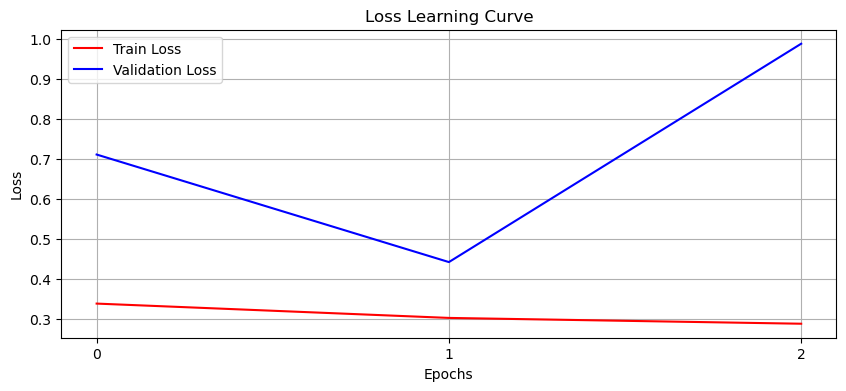

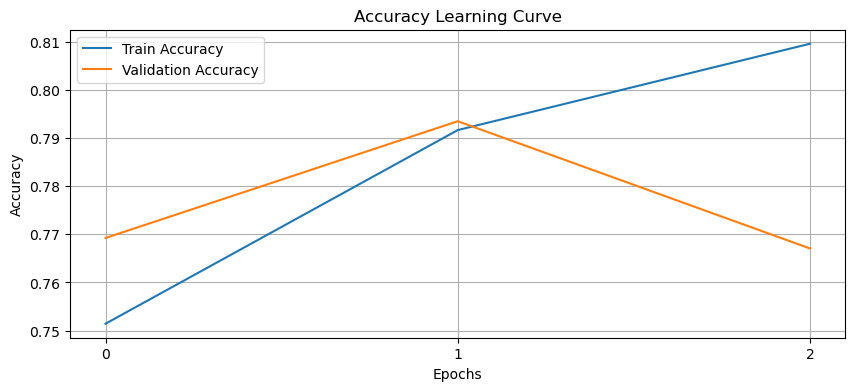

In [96]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_loss_history, color="r")
plt.xticks(range(epochs))
plt.plot(valid_loss_history, color="b")
plt.xticks(range(epochs))
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
ax.grid(True)

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(train_accuracy_history)
plt.xticks(range(epochs))
plt.plot(valid_accuracy_history)
plt.xticks(range
           (epochs))

plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
ax.grid(True)

In [ ]:
print("mean accuracy = : {:3.2%}".format(np.mean(valid_accuracy_history)))

In [ ]:
predicted[0].argmax(-1)

In [ ]:
predicted

In [ ]:
predict=[]

In [ ]:
for count, i in enumerate(predicted): 
    print(coun
    predict.append(i.argmax(-1))

In [ ]:
predict

In [ ]:
actual

In [ ]:
len(prediction)

In [ ]:
len(actual)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
confmat = confusion_matrix(y_true=y_batch, y_pred=y_predicted)
print(confmat)

In [ ]:
X_batch.shape

In [ ]:
y_batch

In [ ]:
(y_predicted)

In [ ]:
y_predicted.argmax(-1)

In [ ]:
y_batch

In [ ]:
# Compare the tensors element-wise
matches = torch.eq(y_predicted.argmax(-1), y_batch)

# Count the number of matches
num_matches = matches.sum().item()

# Display the number of matching values
print(f'Number of matching values: {num_matches}')

In [ ]:
12/14

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch)

In [ ]:
torch.sum(y_predicted.argmax(-1) == y_batch).item()